In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from emnist import get_emnist_data_loaders
train_loader, val_loader = get_emnist_data_loaders()

In [43]:
from models.crnn.crnn import CRNN
from models.lstm_cnn.lstm_cnn import CNN_LSTM
import torch.nn as nn
from training.trainer import Trainer
import hyperparameter as hp
import torch
from evaluation.loss import plot_loss


crnn = CRNN(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)
lstm = CNN_LSTM(hp.GRU_HIDDEN_SIZE, hp.GRU_NUM_LAYERS, hp.NUM_CLASSES, hp.CNN_OUTPUT_HEIGHT)

models = {
    "crnn": crnn,
    "lstm_cnn": lstm
}

crnn_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)
lstm_criterion = nn.CTCLoss(blank=hp.BLANK_LABEL, reduction='mean', zero_infinity=True)

criterions = {
    "crnn": crnn_criterion,
    "lstm_cnn": lstm_criterion
}

crnn_optimizer = torch.optim.Adam(crnn.parameters(), lr=hp.LEARNING_RATE)
lstm_optimizer = torch.optim.Adam(lstm.parameters(), lr=hp.LEARNING_RATE)

optimizers = {
    "crnn": crnn_optimizer,
    "lstm_cnn": lstm_optimizer
}

crnn_trainer = Trainer(models["crnn"], criterions["crnn"], optimizers["crnn"], train_loader, val_loader, hp.EPOCHS, {
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
lstm_trainer =  Trainer(models["lstm_cnn"], criterions["lstm_cnn"], optimizers["lstm_cnn"], train_loader, val_loader, hp.EPOCHS, {
        "blank_label": hp.BLANK_LABEL,
        "cnn_output_width": hp.CNN_OUTPUT_WIDTH,
    })
trainers = {
    "crnn": crnn_trainer,
    "lstm_cnn": lstm_trainer
}

metrics_global = {}
for model_name, trainer in trainers.items():
    print(f"Training {model_name}")
    metrics = trainer.train_validate_test()
    metrics_global[model_name] = metrics
    print(f"Finished training {model_name}")

    # Save the trained model
    torch.save(trainer.model.state_dict(), 'models/' + model_name + '/model.pth')

Training crnn
100%|██████████| 125/125 [00:38<00:00,  3.27it/s]
EPOCH 1/10 - TRAINING. Correct: 157/8000 = 0.0196 - Average CER Score: 0.902
100%|██████████| 2000/2000 [00:12<00:00, 163.40it/s]
EPOCH 1/10 - TESTING. Correct: 727/2000 = 0.3635 - Average CER Score: 0.269
100%|██████████| 125/125 [00:39<00:00,  3.14it/s]
EPOCH 2/10 - TRAINING. Correct: 5462/8000 = 0.6827 - Average CER Score: 0.501
100%|██████████| 2000/2000 [00:13<00:00, 152.60it/s]
EPOCH 2/10 - TESTING. Correct: 1600/2000 = 0.8000 - Average CER Score: 0.159
100%|██████████| 125/125 [00:40<00:00,  3.07it/s]
EPOCH 3/10 - TRAINING. Correct: 6821/8000 = 0.8526 - Average CER Score: 0.347
100%|██████████| 2000/2000 [00:14<00:00, 137.21it/s]
EPOCH 3/10 - TESTING. Correct: 1685/2000 = 0.8425 - Average CER Score: 0.119
100%|██████████| 125/125 [00:40<00:00,  3.11it/s]
EPOCH 4/10 - TRAINING. Correct: 7190/8000 = 0.8988 - Average CER Score: 0.266
100%|██████████| 2000/2000 [00:13<00:00, 149.02it/s]
EPOCH 4/10 - TESTING. Correct: 17

In [44]:
for model_name, model in models.items():
    # Load model

    base_path = 'models/' + model_name + "/"
    model_path = base_path + 'model.pth'
    model = model.to("cpu")
    model.load_state_dict(torch.load(model_path))

    # Plot the trained model
    plot_loss(model_name=model_name, train_loss_per_epoch=trainer.epoch_train_cers, val_loss_per_epoch=trainer.epoch_val_cers, figure_evaluation_dir=base_path)

models/crnn/crnn_loss.png
models/lstm_cnn/lstm_cnn_loss.png


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

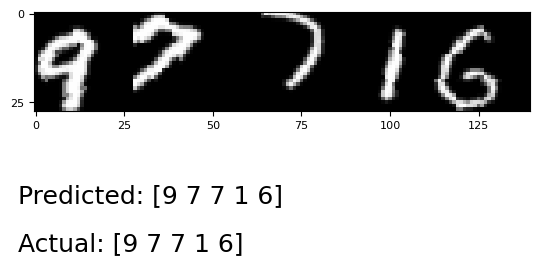

In [45]:

# ============================================ TESTING =================================================================
number_of_test_imgs = 1
test_preds = []
(x_test, y_test) = next(iter(train_loader))
y_pred = trainer.model(x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]))
y_pred = y_pred.permute(1, 0, 2)
_, max_index = torch.max(y_pred, dim=2)
for i in range(x_test.shape[0]):
    raw_prediction = list(max_index[:, i].detach().cpu().numpy())
    prediction = torch.IntTensor([c for c, _ in groupby(raw_prediction) if c != hp.BLANK_LABEL])
    test_preds.append(prediction)

for j in range(len(x_test)):
    if j == number_of_test_imgs:
        break

    mpl.rcParams["font.size"] = 8
    plt.imshow(x_test[j], cmap='gray')
    mpl.rcParams["font.size"] = 18
    plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
    plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
    plt.show()